### Importing Necessary Libraries

In [14]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras import layers
from keras.layers import Dense, BatchNormalization, MaxPooling1D, Conv1D, Flatten, Dropout, LeakyReLU
from keras.optimizers import SGD, Adam
from keras import losses
from keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import os
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import pylab as py

ModuleNotFoundError: No module named 'statsmodels'

### Reading data from csv file

In [4]:
data = pd.read_csv("train.csv")

### Visualizing the dataframe

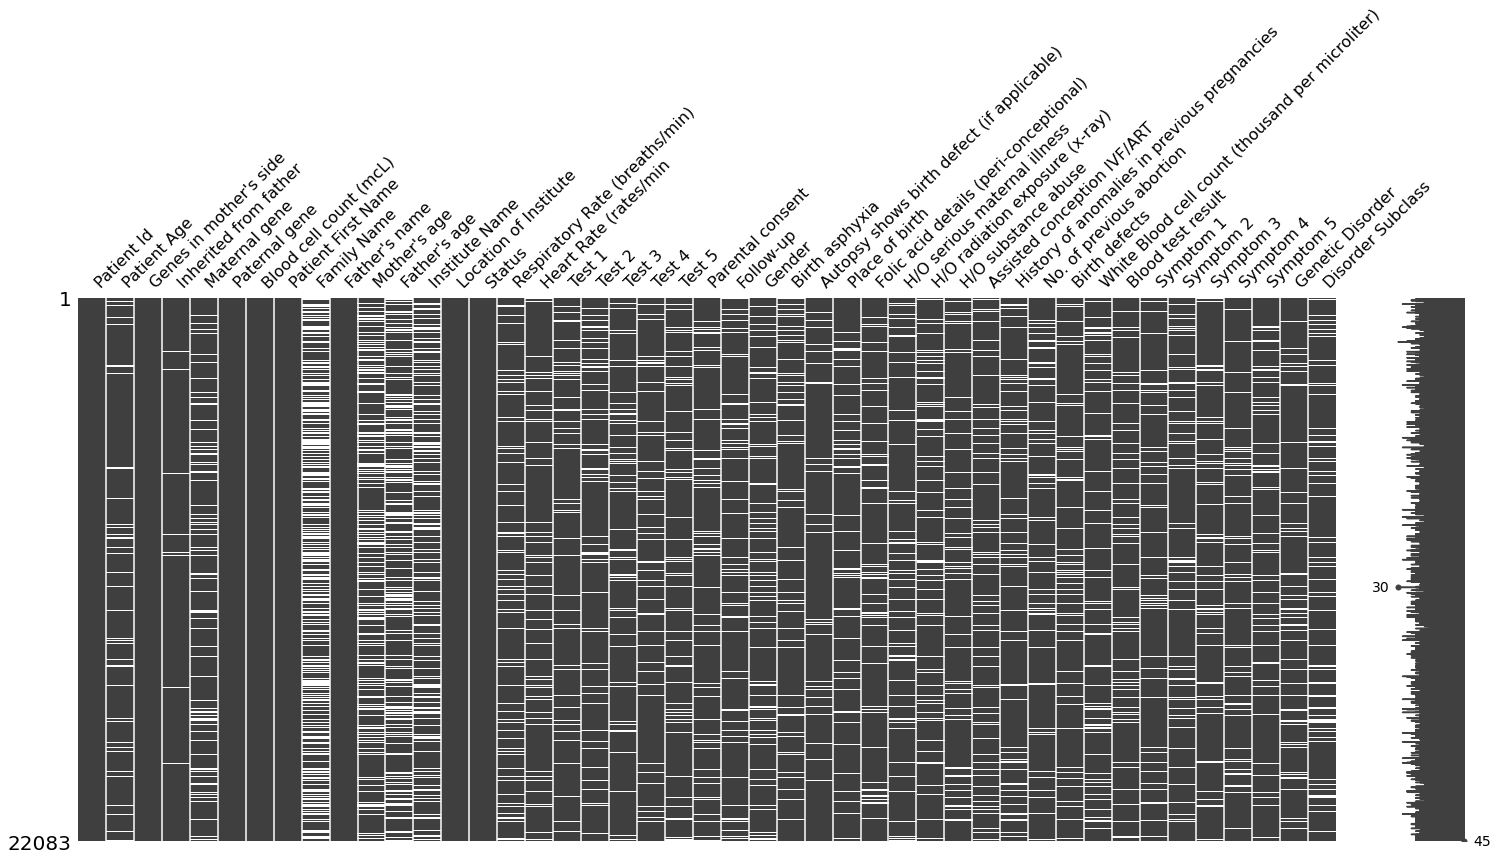

In [5]:
msno.matrix(data)
plt.show()

### Dropping columns that don't contribute towards making the model

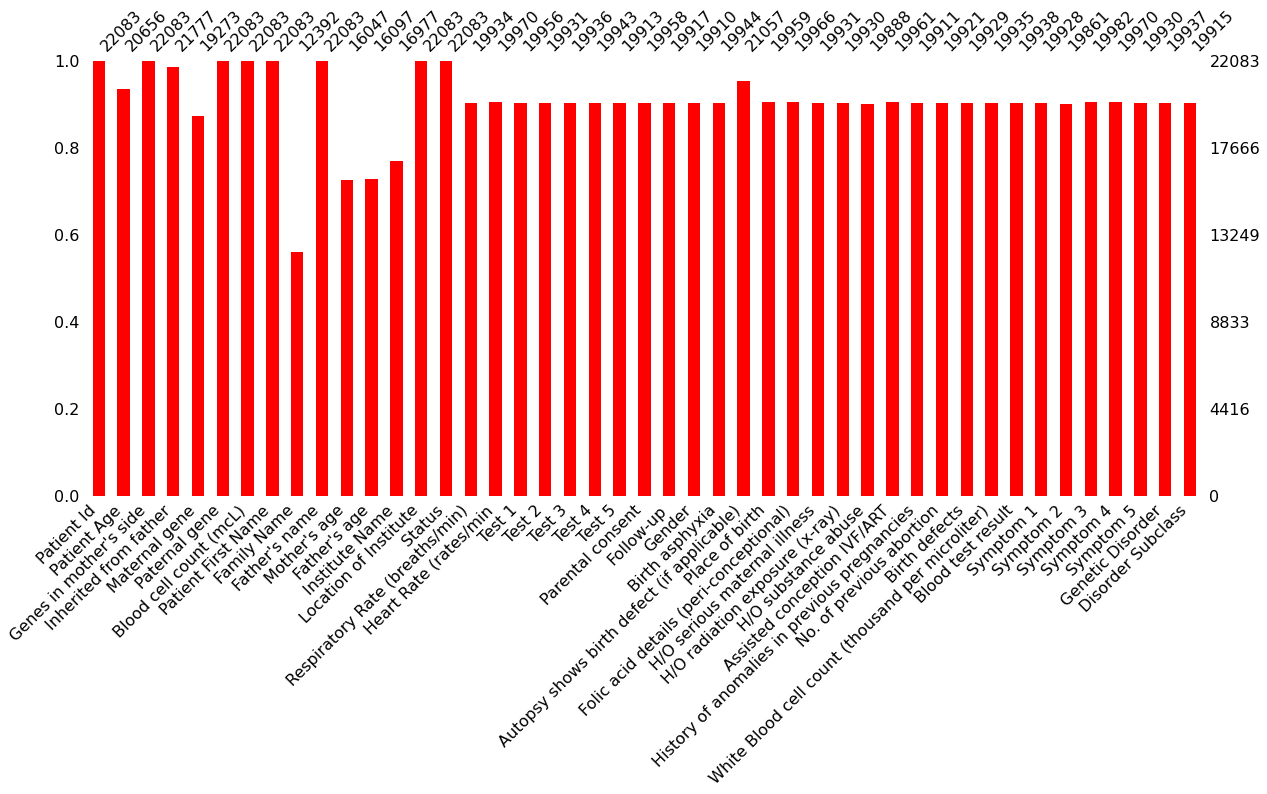

In [6]:
msno.bar(data, color='r', figsize=(20, 8))
plt.show()

In [7]:
drop_cols = ["Patient Id", "Patient First Name", "Family Name", "Father's name", "Institute Name",
             "Location of Institute", "Mother's age", "Father's age",
             "Test 1", "Test 2", "Test 3", "Test 4", "Test 5", "Parental consent", "Place of birth"]
data.drop(drop_cols, inplace=True, axis=1)

### Replace missing values with Nan

In [8]:
data.replace('', np.NaN)

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,2.0,Yes,No,Yes,No,4.760603,Alive,Normal (30-60),Normal,High,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,4.0,Yes,Yes,No,No,4.910669,Deceased,Tachypnea,Normal,High,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,6.0,Yes,No,No,No,4.893297,Alive,Normal (30-60),Tachycardia,Low,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,12.0,Yes,No,Yes,No,4.705280,Deceased,Tachypnea,Normal,High,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,11.0,Yes,No,NaN,Yes,4.720703,Alive,Tachypnea,Tachycardia,Low,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22078,4.0,Yes,Yes,Yes,No,5.258298,Deceased,Normal (30-60),Tachycardia,High,...,Multiple,6.584811,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
22079,8.0,No,Yes,No,Yes,4.974220,Alive,Normal (30-60),Normal,High,...,Multiple,7.041556,inconclusive,1.0,1.0,1.0,1.0,0.0,Multifactorial genetic inheritance disorders,Diabetes
22080,8.0,Yes,No,Yes,No,5.186470,Deceased,Tachypnea,Normal,High,...,Singular,7.715464,normal,0.0,0.0,0.0,1.0,NaN,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy
22081,7.0,Yes,No,Yes,Yes,4.858543,Alive,Tachypnea,Tachycardia,High,...,Multiple,8.437670,abnormal,1.0,1.0,1.0,0.0,0.0,NaN,Leigh syndrome


### Segmenting columns into categorical and numeric type

In [9]:
encode_cols_x = ["Genes in mother's side", "Inherited from father", "Maternal gene", "Paternal gene", "Status",
                 "Respiratory Rate (breaths/min)", "Heart Rate (rates/min", "Follow-up", "Gender", "Birth asphyxia",
                 "Autopsy shows birth defect (if applicable)", "Folic acid details (peri-conceptional)",
                 "H/O serious maternal illness", "H/O radiation exposure (x-ray)", "H/O substance abuse",
                 "Assisted conception IVF/ART", "History of anomalies in previous pregnancies", "Birth defects",
                 "Blood test result", "Symptom 1", "Symptom 2", "Symptom 3", "Symptom 4", "Symptom 5"]

num_cols_x = ["Patient Age", "Blood cell count (mcL)", "No. of previous abortion",
              "White Blood cell count (thousand per microliter)"]

encode_cols_y = ["Genetic Disorder", "Disorder Subclass"]

<AxesSubplot:xlabel='Patient Age', ylabel='Genetic Disorder'>

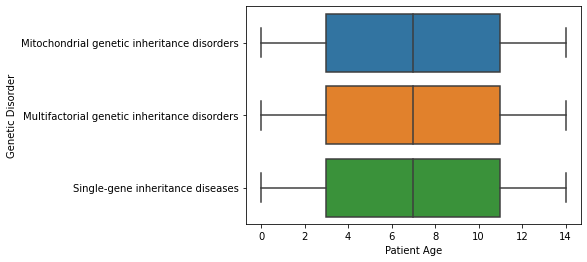

In [10]:
sns.boxplot(data=data, x=data["Patient Age"], y=data["Genetic Disorder"])

In [12]:
sm.qqplot(data["Patient Age"], line ='45')
py.show()

NameError: name 'sm' is not defined

### Pre-processing data

In [12]:
cols_x_imputed = []
cols_y_imputed = []

data["Blood cell count (mcL)"] = data["Blood cell count (mcL)"].round(3)
data["White Blood cell count (thousand per microliter)"] = data["White Blood cell count (thousand per microliter)"].round(3)

for col in encode_cols_x:
    mode = data[col].mode()[0]
    data[col + "_imputed"] = data[col]
    data[col + "_imputed"].fillna(mode, inplace=True)

for col in encode_cols_y:
    mode = data[col].mode()[0]
    data[col + "_imputed"] = data[col]
    data[col + "_imputed"].fillna(mode, inplace=True)

### Dropping columns after doing pre-processing

In [13]:
for col in encode_cols_x:
    col += "_imputed"
    cols_x_imputed.append(col)
data.drop(encode_cols_x, inplace=True, axis=1)

for col in encode_cols_y:
    col = col + "_imputed"
    cols_y_imputed.append(col)
data.drop(encode_cols_y, inplace=True, axis=1)

### Transforming categorical columns by use of LabelEncoder method

In [14]:
data[cols_x_imputed] = data[cols_x_imputed].apply(LabelEncoder().fit_transform)
data[cols_y_imputed] = data[cols_y_imputed].apply(LabelEncoder().fit_transform)
y1 = np.array(data[cols_y_imputed[0]])
y2 = np.array(data[cols_y_imputed[1]])
data.drop(cols_y_imputed, inplace=True, axis=1)

### Replacing missing values in numeric cols by mean of that column

In [15]:
for col in num_cols_x:
    mean = data[col].mean()
    data[col].fillna(mean, inplace=True)
    
new_x = np.array(data[num_cols_x])
pca = PCA(n_components=2)
pca.fit_transform(new_x)

array([[-4.99167438e+00,  2.33475189e+00],
       [-2.95947482e+00, -1.98526404e+00],
       [-9.78916488e-01, -2.26075258e-03],
       ...,
       [ 1.02427323e+00,  2.36364549e-01],
       [ 2.11734737e-02,  9.49441696e-01],
       [ 3.99336888e+00,  3.73656546e+00]])

In [16]:
# data.interpolate(method='linear')
x = np.array(data)

print(x.shape)

# print(data["Patient Age"][:25])
# data.interpolate(method='polynomial', order=2)
# print(data["Patient Age"][:25])

# for col in num_cols_x:
#     data[col + "_imputed"] = data[col]
#     data[col + "_imputed"].fillna(method='ffill')
# print(data["Patient Age_imputed"][:25])

# print(data.head())

# print(data.info())

(22083, 28)


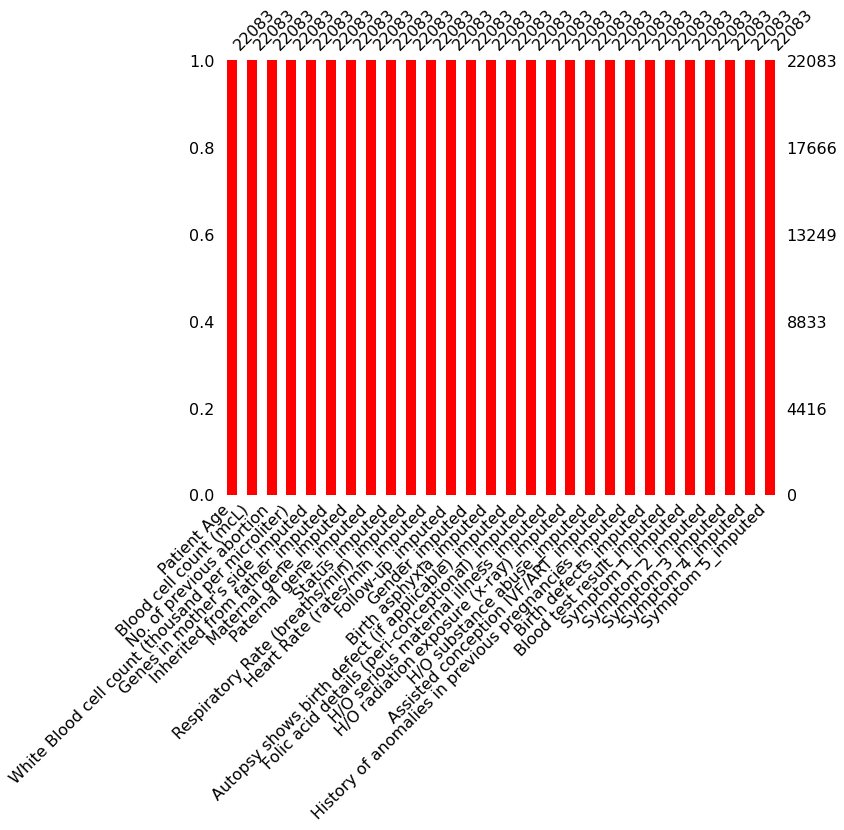

In [17]:
msno.bar(data, color='r', figsize=(10, 8))
plt.show()

False
Epoch 1/15
518/518 [==============================] - 129s 243ms/step - loss: 0.9309 - accuracy: 0.5578
Epoch 2/15
518/518 [==============================] - 118s 228ms/step - loss: 0.9184 - accuracy: 0.5618
Epoch 3/15
518/518 [==============================] - 124s 240ms/step - loss: 0.9186 - accuracy: 0.5620
Epoch 4/15
518/518 [==============================] - 127s 244ms/step - loss: 0.9197 - accuracy: 0.5612
Epoch 5/15
518/518 [==============================] - 128s 246ms/step - loss: 0.9182 - accuracy: 0.5627
Epoch 6/15
518/518 [==============================] - 127s 246ms/step - loss: 0.9182 - accuracy: 0.5609
Epoch 7/15
518/518 [==============================] - 128s 246ms/step - loss: 0.9181 - accuracy: 0.5611
Epoch 8/15
518/518 [==============================] - 138s 267ms/step - loss: 0.9171 - accuracy: 0.5611
Epoch 9/15
518/518 [==============================] - 135s 261ms/step - loss: 0.9186 - accuracy: 0.5627
Epoch 10/15
518/518 [==============================] - 81s

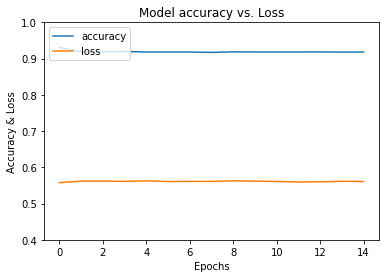

In [18]:
total_null = data.isnull().sum().sort_values(ascending=False)
percent = ((data.isnull().sum() / data.isnull().count()) * 100).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent], axis=1, keys=['Total', 'Percent'])
# print(missing_data)

print(np.isnan(x).any())
# print(x[:10])

model = Sequential()
model.add(Conv1D(256, 5, activation="relu", input_shape=(28, 1)))
model.add(Dropout(0.25))
# model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(512, 5, activation="relu", padding="same"))
model.add(Dropout(0.25))
# model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(256, 5, activation="relu", padding="same"))
model.add(Dropout(0.25))
# model.add(MaxPooling1D(2, padding='same'))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(3, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(learning_rate=1), metrics=['accuracy'])

x_train, x_test, y_train, y_test = train_test_split(x, y1, test_size=0.25)

my_model = model.fit(x_train, y_train, epochs=15, verbose=1)
testing = model.evaluate(x_test, y_test, verbose=0)

plt.plot(my_model.history['loss'])
plt.plot(my_model.history['accuracy'])
plt.title("Model accuracy vs. Loss")
plt.ylabel('Accuracy & Loss')
plt.xlabel("Epochs")
plt.ylim(bottom=0.4, top=1)
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()